In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# ---------------------------------------------------------
# 1. Define the cmpLS function
# ---------------------------------------------------------
def cmp_ls(x, t):
    """
    Estimate apparent NMO velocity and zero offset 
    two-way travel time from CMP using least squares.
    """
    # Ensure inputs are numpy arrays
    x = np.asarray(x)
    t = np.asarray(t)
    
    d2 = t**2 # square data to linearize equation
    
    # Design matrix: column of 1s and column of x^2
    G = np.column_stack((np.ones(len(t)), x**2))
    
    # Least squares solution: m = (G'G)^-1 G' d2
    G_transpose = G.T
    m = np.linalg.inv(G_transpose @ G) @ G_transpose @ d2
    
    # Return best fit velocity and zero-offset travel time
    t0 = np.sqrt(m[0])
    v = np.sqrt(1 / m[1])
    
    # Predict best fit data for vector x
    d_hat1 = G @ m
    
    # Calculate residuals and assess error statistics
    res1 = d2 - d_hat1
    
    # Variance (s^4)
    Var = (res1.T @ res1) / (len(t) - len(m))
    
    # Standard deviation (units in s^2)
    sig = np.sqrt(Var)
    
    # Covariance matrix
    cov = Var * np.linalg.inv(G_transpose @ G)
    
    return v, t0, sig, cov, d_hat1



In [11]:
# ---------------------------------------------------------
# 2. Main Script: Imogene and Gilpin Rock Glaciers
# ---------------------------------------------------------

# Constants
C = 0.3 # velocities calculated in meters/nanosecond

# Load data (skipping 3 header lines as in MATLAB)
# Note: Ensure the column names exactly match your CSV files. 
# Pandas might parse them slightly differently than MATLAB.
imo = pd.read_csv("cmp3-Point.csv", skiprows=3)
air = pd.read_csv("cmp3_air-Point.csv", skiprows=3)
ref = pd.read_csv("cmp3_ref-Point.csv", skiprows=3)


In [12]:


# Extract columns into numpy arrays
imo_x = imo['Position(m)'].values
imo_t = imo['Time(ns)'].values

# Compute least squares fit
v1, t01, sig1, cov1, d_hat1 = cmp_ls(imo_x, imo_t)

VLS = [v1]
T0LS = [t01]

# Calculate theoretical travel time curve
t1 = np.sqrt(t01**2 + 4 * (imo_x / 2)**2 / v1**2)

t0a = np.min(imo_t) # t0 pick (ns)

# NMO velocities (avoiding division by zero or negative square roots implicitly)
va = np.sqrt(imo_x**2 / (imo_t**2 - t0a**2))

# X array for plotting lines
X = np.arange(0, 41)

# Extract Air and Refracted wave data
L1r_x = ref['Position(m)'].values
L1r_t = ref['Time(ns)'].values
L1s_x = air['Position(m)'].values
L1s_t = air['Time(ns)'].values

# Linear fits for air and refracted waves
Rm = np.polyfit(L1r_x, L1r_t, 1)
Ref = Rm[0] * X + Rm[1]

Sm = np.polyfit(L1s_x, L1s_t, 1)
Surf = Sm[0] * X + Sm[1]

Vs = 1 / Sm[0]
Vr = 1 / Rm[0]

print(f"Air wave: {Vs}")
print(f"Refracted wave: {Vr}")

T0 = [t0a]
# MATLAB takes the mean of the last 11 elements: length(va)-10:length(va)
V = [np.mean(va[-11:])] 

# Real dielectric permittivity
ea = C**2 / va**2 

# Propagate travel time standard deviations to velocity uncertainty
sqrt1 = np.sqrt(sig1) * np.ones(len(t1))

v1p, t01p, _, _, _ = cmp_ls(imo_x, t1 + sqrt1) # v and t0 due to positive time uncertainty
v1n, t01n, _, _, _ = cmp_ls(imo_x, t1 - sqrt1) # v and t0 due to negative time uncertainty

# Array of velocity error
neg = [v1 - v1p]
pos = [v1n - v1]

# Best-fit depth bounds
d1 = 0.5 * v1 * t01
d1n = 0.5 * v1n * t01
d1p = 0.5 * v1p * t01



Air wave: 0.29262668926836466
Refracted wave: 0.16156944310632504


/var/tmp/ipykernel_1264396/364160086.py:17: RuntimeWarning: divide by zero encountered in divide
  va = np.sqrt(imo_x**2 / (imo_t**2 - t0a**2))


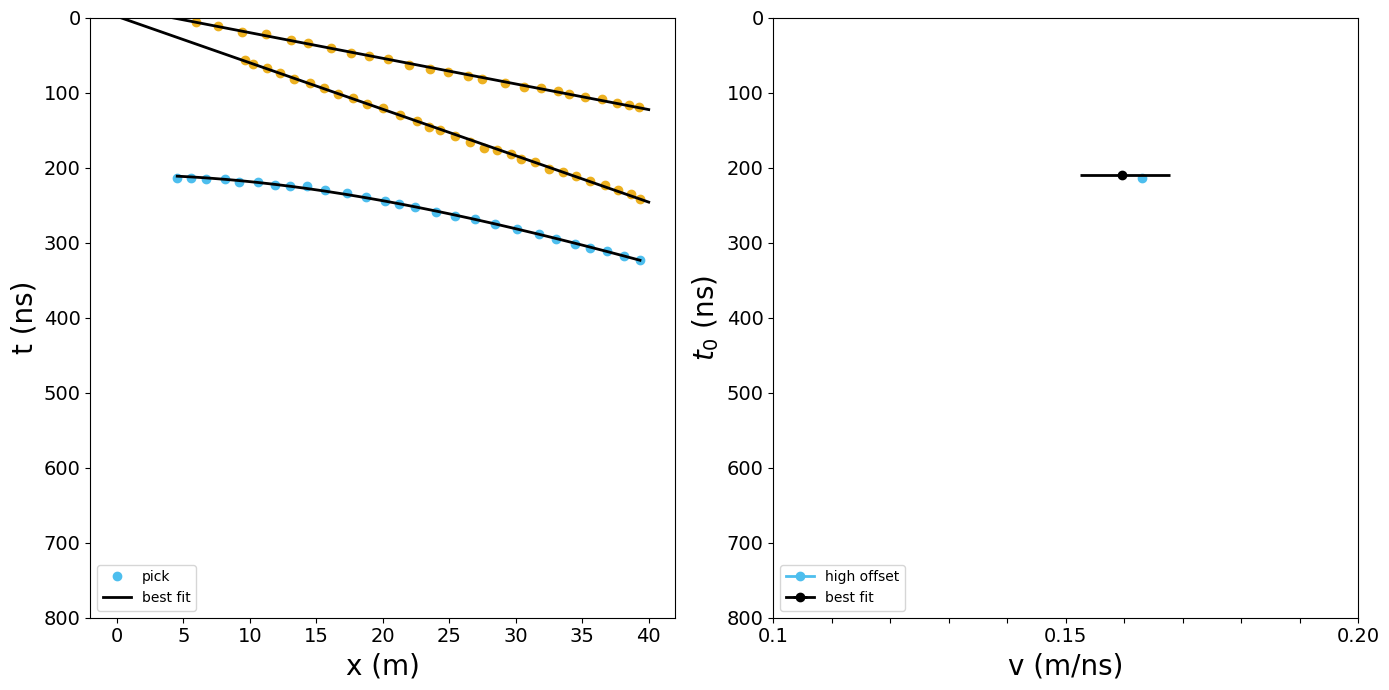

In [8]:
# ---------------------------------------------------------
# 3. Plotting Figure 1
# ---------------------------------------------------------
fig1 = plt.figure(1, figsize=(14, 7))

# Subplot 1 (Figure S6 B & C)
ax1 = fig1.add_subplot(1, 2, 1)
ax1.plot(L1s_x, L1s_t, 'o', color='#EDB120', linewidth=2)
ax1.plot(L1r_x, L1r_t, 'o', color='#EDB120', linewidth=2)
ax1.plot(X, Surf, 'k-', linewidth=2)
ax1.plot(X, Ref, 'k-', linewidth=2)
p1, = ax1.plot(imo_x, imo_t, 'o', color='#4DBEEE', linewidth=2, label='pick')
p2, = ax1.plot(imo_x, t1, 'k-', linewidth=2, label='best fit')

ax1.invert_yaxis() # Equivalent to MATLAB's `axis ij`
ax1.set_xlabel('x (m)', fontsize=20)
ax1.set_ylabel('t (ns)', fontsize=20)
ax1.set_ylim(800, 0) # y-axis limits (inverted)
ax1.tick_params(labelsize=14)
ax1.legend(handles=[p1, p2], loc='lower left')

# Subplot 2
ax2 = fig1.add_subplot(1, 2, 2)
p3, = ax2.plot(V, T0, '-o', linewidth=2, color='#4DBEEE', label='high offset')

# Errorbar formatting in Python requires passing absolute errors to xerr
p4 = ax2.errorbar(VLS, T0LS, xerr=[neg, pos], fmt='k-o', linewidth=2, label='best fit')

ax2.invert_yaxis()
ax2.set_xlabel('v (m/ns)', fontsize=20)
ax2.set_ylabel('$t_0$ (ns)', fontsize=20)
ax2.set_ylim(800, 0)
ax2.set_xlim(0.1, 0.20)
ax2.set_xticks(np.arange(0.1, 0.21, 0.01))
ax2.set_xticklabels(['0.1', '', '', '', '', '0.15', '', '', '', '', '0.20'])
ax2.tick_params(labelsize=14)
ax2.legend(handles=[p3, p4], loc='lower left')

plt.tight_layout()

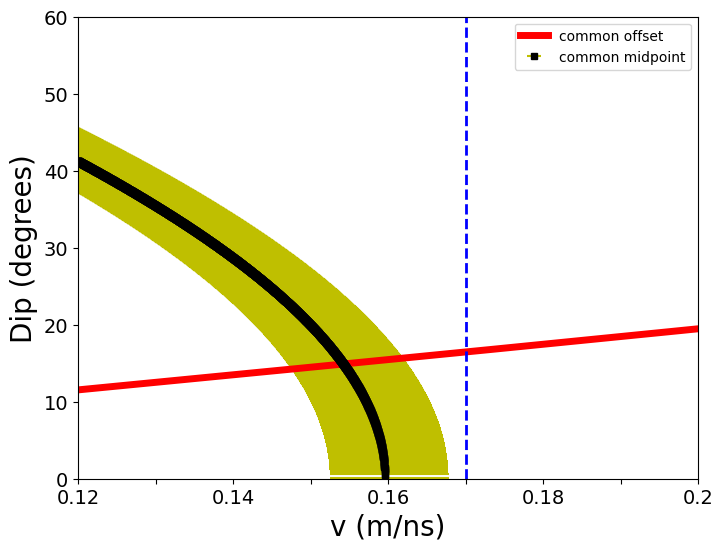

In [9]:


# ---------------------------------------------------------
# 4. Plotting Figure 2
# ---------------------------------------------------------
# Compare dip angle equations from common offset and cmp
delta_t = 100
delta_x = 30
vrange = np.arange(0.08, 0.24001, 0.00001)

# MATLAB's acosd handles values out of [-1, 1] by creating imaginary numbers, 
# then filters them with real(theta_cmp)>0. 
# In Python, we calculate the bounds to avoid invalid math warnings.
ratio = vrange / v1
valid_mask = ratio <= 1.0
vrange_valid = vrange[valid_mask]
theta_cmp_valid = np.degrees(np.arccos(ratio[valid_mask]))

theta_coh = np.degrees(np.arcsin(vrange * delta_t / (2 * delta_x)))

# Arrays of uncertainties for wave speed/dip plot
NEG = np.ones(len(vrange_valid)) * neg[0]
POS = np.ones(len(vrange_valid)) * pos[0]

vice = np.array([[0, 90], [0.17, 0.17]])

fig2 = plt.figure(2, figsize=(8, 6))
ax3 = fig2.add_subplot(111)

# Plot valid cmp errors and line
ax3.errorbar(vrange_valid, theta_cmp_valid, xerr=[NEG, POS], fmt='ys', 
             markerfacecolor='k', markeredgecolor='k', markersize=5, label='common midpoint')

ax3.plot(vrange, theta_coh, 'r-', linewidth=5, label='common offset')
ax3.plot(vice[1, :], vice[0, :], 'b--', linewidth=2) # X = row 2, Y = row 1

ax3.set_xlabel('v (m/ns)', fontsize=20)
ax3.set_ylabel('Dip (degrees)', fontsize=20)
ax3.legend()
ax3.set_xlim(0.12, 0.2)
ax3.set_ylim(0, 60)
ax3.set_xticks(np.arange(0.12, 0.21, 0.01))
ax3.set_xticklabels(['0.12', '', '0.14', '', '0.16', '', '0.18', '', '0.2'])
ax3.tick_params(labelsize=14)

plt.show()





In [10]:
# ---------------------------------------------------------
# 5. Terminal Outputs
# ---------------------------------------------------------
print("\n--- Results ---")
print(f"Best Fit Velocity: {v1:.5f}")
print(f"Standard Deviation: {(v1n - v1p) / 2:.5f}")
print(f"Best Fit Dielectric Constant: {(C / v1)**2:.5f}")
print(f"Max. Dielectric Constant: {(C / v1p)**2:.5f}")
print(f"Min. Dielectric Constant: {(C / v1n)**2:.5f}")
print(f"Best Fit T0: {t01:.5f}")
print(f"Best Fit Depth: {d1:.5f}")


--- Results ---
Best Fit Velocity: 0.15960
Standard Deviation: 0.00766
Best Fit Dielectric Constant: 3.53325
Max. Dielectric Constant: 3.87065
Min. Dielectric Constant: 3.19585
Best Fit T0: 209.58612
Best Fit Depth: 16.72502
